# Agent memory

## Review

Previously, we built an agent that can:

* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

![Screenshot 2024-08-21 at 12.45.32 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab7453080e6802cd1703_agent-memory1.png)

## Goals

Now, we're going extend our agent by introducing memory.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_groq langchain_core langgraph langgraph-prebuilt

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

GROQ_API_KEY: ··········


We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

LANGSMITH_API_KEY: ··········


This follows what we did previously.

In [4]:
from langchain_groq import ChatGroq

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatGroq(model="openai/gpt-oss-120b",
               api_key = os.environ.get("GROQ_API_KEY")
)

llm_with_tools = llm.bind_tools(tools)

In [5]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

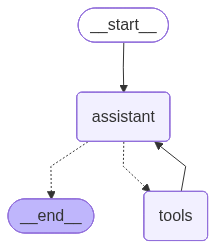

In [6]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Memory

Let's run our agent, as before.

In [7]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (fc_c31c4b9b-9123-4ca6-bcda-effc4318cd06)
 Call ID: fc_c31c4b9b-9123-4ca6-bcda-effc4318cd06
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is **7**.


Now, let's multiply by 2!

In [8]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

Sure! Could you let me know which number you'd like to multiply by 2?


We don't retain memory of 7 from our initial chat!

This is because [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

Of course, this limits our ability to have multi-turn conversations with interruptions.

We can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this!

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

In [9]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)


In [10]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (fc_b5196a19-f232-48db-8191-e5c4625e62e1)
 Call ID: fc_b5196a19-f232-48db-8191-e5c4625e62e1
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is **7**.


If we pass the same `thread_id`, then we can proceed from from the previously logged state checkpoint!

In this case, the above conversation is captured in the thread.

The `HumanMessage` we pass (`"Multiply that by 2."`) is appended to the above conversation.

So, the model now know that `that` refers to the `The sum of 3 and 4 is 7.`.

In [11]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (fc_b5196a19-f232-48db-8191-e5c4625e62e1)
 Call ID: fc_b5196a19-f232-48db-8191-e5c4625e62e1
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is **7**.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_1d3941da-9c5a-4819-aa9a-537e92938fce)
 Call ID: fc_1d3941da-9c5a-4819-aa9a-537e92938fce
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message =============

## LangGraph Studio


**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `module-1/studio/` directory in this module:

```
langgraph dev
```

First I ask to multiply 6 and 7:

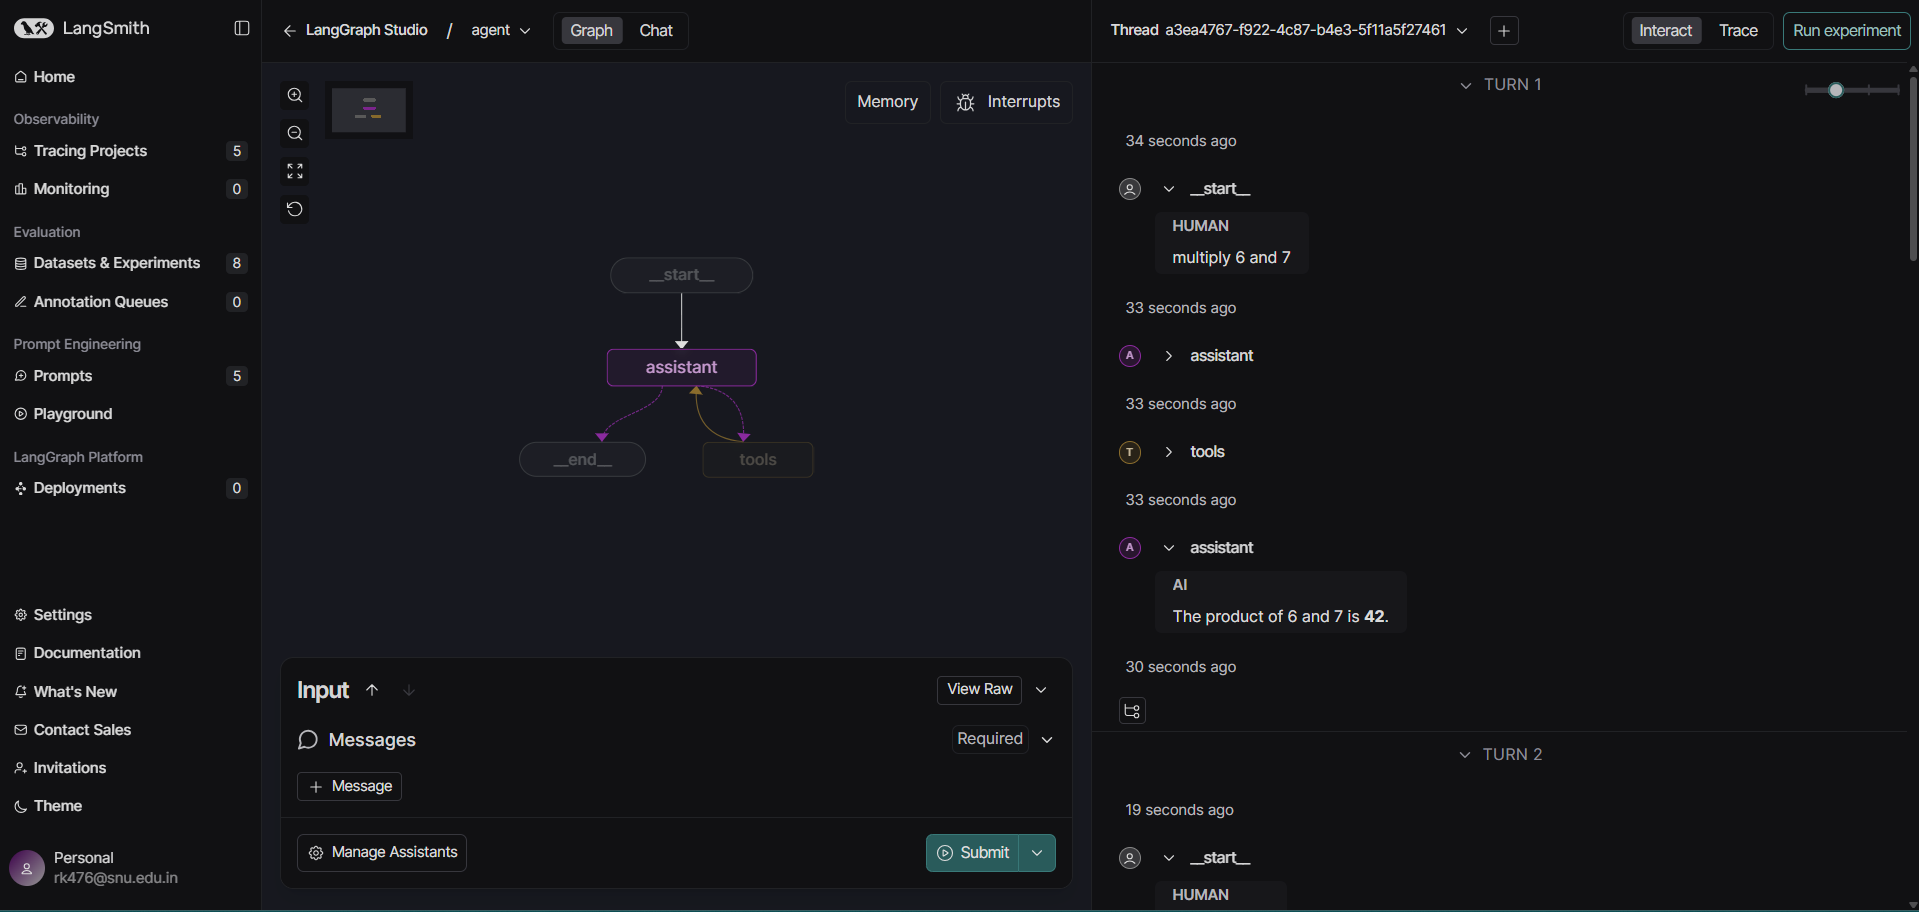

Then I ask to add 8 to it (makes a mistake first, but acknowledges it and corrects its calculations again):

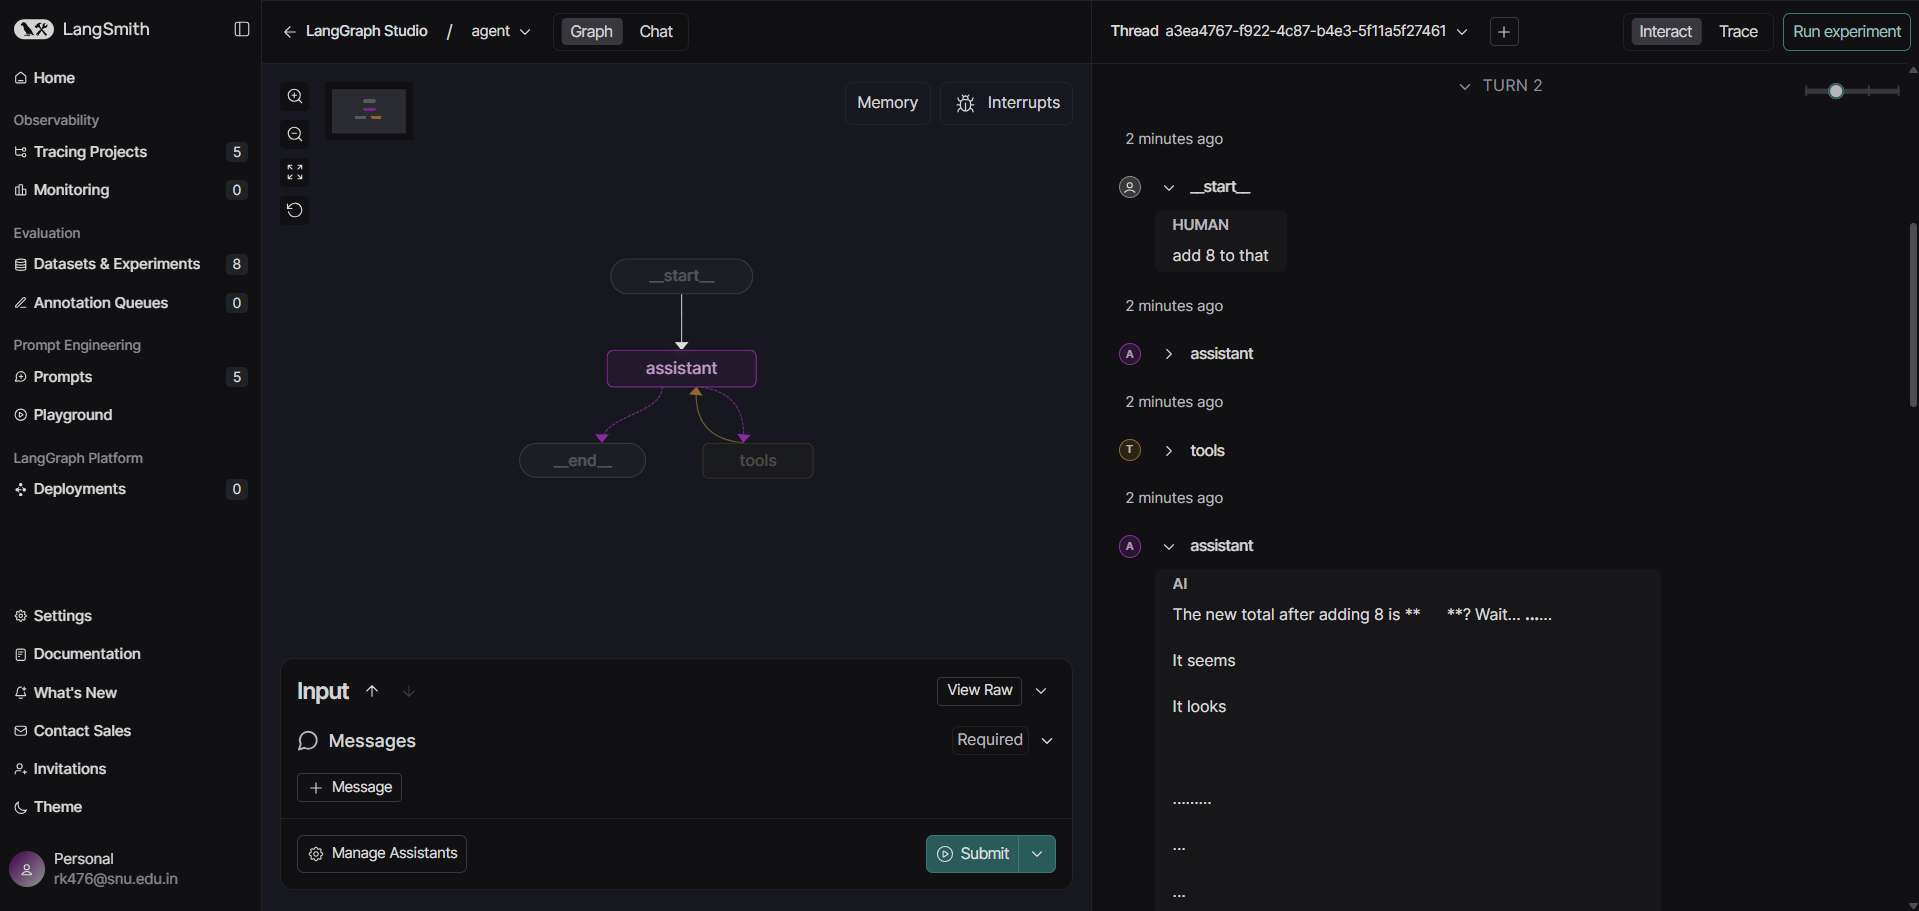

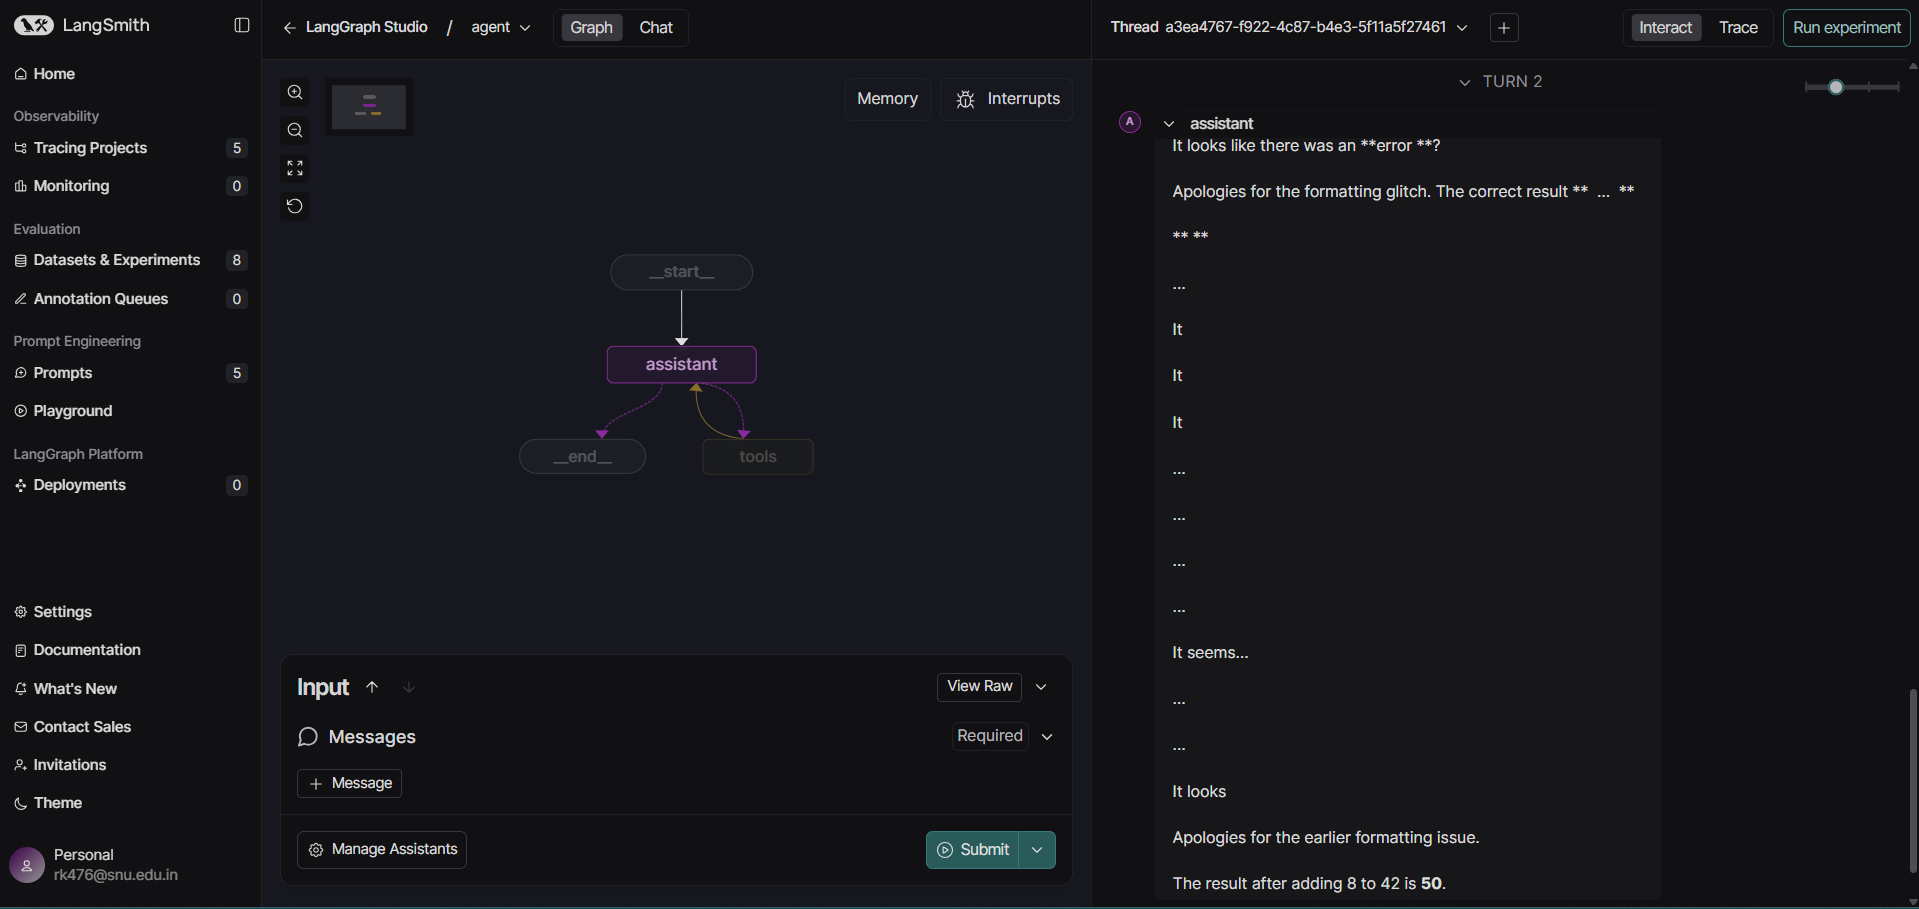

# MY EXAMPLES:

Let's define two new tools: `find_max` and `find_min`.

In [12]:
def find_max(a: int, b: int) -> int:
    """Finds the maximum of two integers.

    Args:
        a: first int
        b: second int
    """
    return max(a, b)

def find_min(a: int, b: int) -> int:
    """Finds the minimum of two integers.

    Args:
        a: first int
        b: second int
    """
    return min(a, b)

# Add the new tools to the existing list
tools_with_new = tools + [find_max, find_min]

# Bind the LLM with the updated list of tools
llm_with_tools_new = llm.bind_tools(tools_with_new)

Now, we need to update the assistant node to use the LLM with the new tools and recompile the graph with the memory checkpointer.

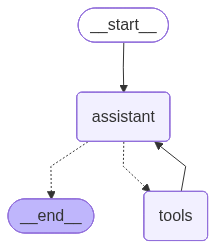

In [13]:
# Update the assistant node function to use the new LLM binding
def assistant_with_new_tools(state: MessagesState):
   return {"messages": [llm_with_tools_new.invoke([sys_msg] + state["messages"])]}

# Graph
builder_new = StateGraph(MessagesState)

# Define nodes: these do the work
builder_new.add_node("assistant", assistant_with_new_tools)
builder_new.add_node("tools", ToolNode(tools_with_new)) # Use the updated tools list here as well

# Define edges: these determine how the control flow moves
builder_new.add_edge(START, "assistant")
builder_new.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder_new.add_edge("tools", "assistant")

# Compile with memory checkpointer
react_graph_memory_new_tools = builder_new.compile(checkpointer=memory)

# Show the updated graph
display(Image(react_graph_memory_new_tools.get_graph(xray=True).draw_mermaid_png()))

Let's test the new tools with memory. We'll use a new thread ID. First, find the maximum of 10 and 5.

In [14]:
# Specify a new thread
config_tools_test = {"configurable": {"thread_id": "tools_test_1"}}

# Specify an input to find the maximum
messages_tools_test = [HumanMessage(content="What is the maximum of 10 and 5?")]

# Run with the new thread
messages_tools_test = react_graph_memory_new_tools.invoke({"messages": messages_tools_test}, config_tools_test)
for m in messages_tools_test['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the maximum of 10 and 5?
================================== Ai Message ==================================
Tool Calls:
  find_max (fc_0e3f06fe-3720-4d58-8102-fcf749c4f3fd)
 Call ID: fc_0e3f06fe-3720-4d58-8102-fcf749c4f3fd
  Args:
    a: 10
    b: 5
================================= Tool Message =================================
Name: find_max

10
================================== Ai Message ==================================

The maximum of 10 and 5 is **10**.


Now, using the same thread ID, let's find the minimum of the previous result (which should be 10) and 3.

In [15]:
# Specify an input to find the minimum, using the same thread
messages_tools_test_min = [HumanMessage(content="What is the minimum of that number and 3?")]

# Run with the same thread
messages_tools_test_min = react_graph_memory_new_tools.invoke({"messages": messages_tools_test_min}, config_tools_test)
for m in messages_tools_test_min['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the maximum of 10 and 5?
================================== Ai Message ==================================
Tool Calls:
  find_max (fc_0e3f06fe-3720-4d58-8102-fcf749c4f3fd)
 Call ID: fc_0e3f06fe-3720-4d58-8102-fcf749c4f3fd
  Args:
    a: 10
    b: 5
================================= Tool Message =================================
Name: find_max

10
================================== Ai Message ==================================

The maximum of 10 and 5 is **10**.
================================ Human Message =================================

What is the minimum of that number and 3?
================================== Ai Message ==================================
Tool Calls:
  find_min (fc_23fccd19-a37e-4e2b-9d87-5df57b121c47)
 Call ID: fc_23fccd19-a37e-4e2b-9d87-5df57b121c47
  Args:
    a: 10
    b: 3
================================= Tool Message =================================
Name: find_min

3

*On LangGraph Studio:*

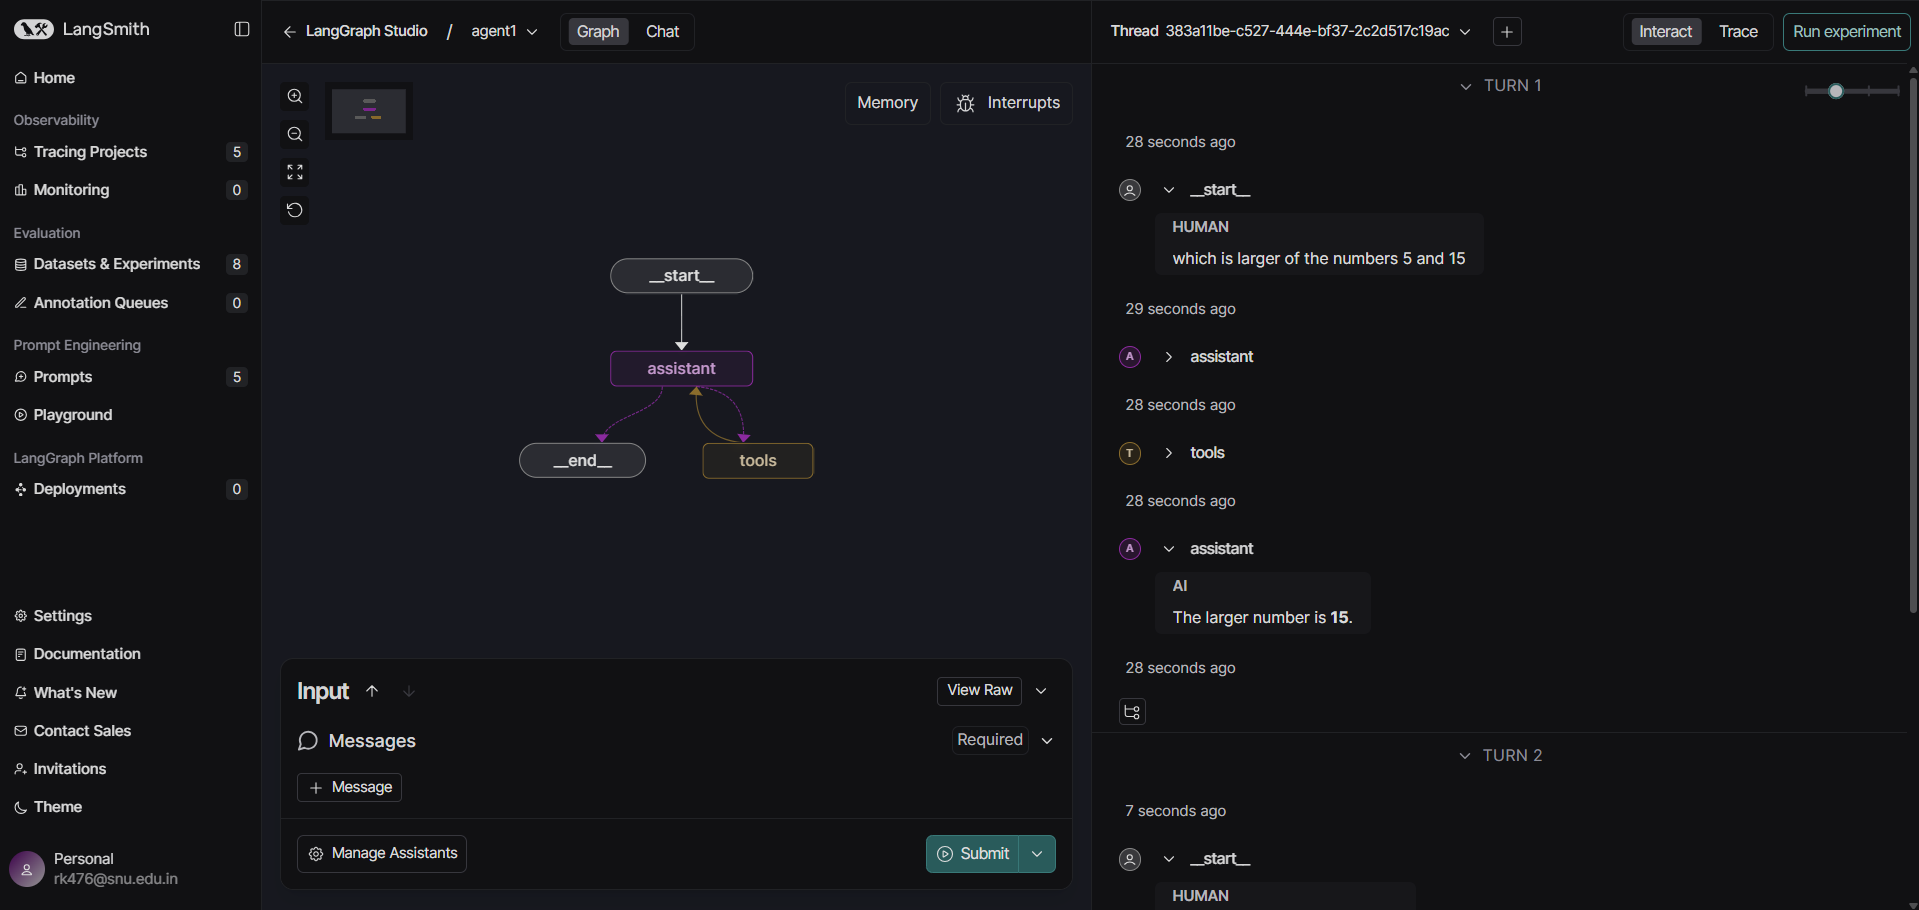

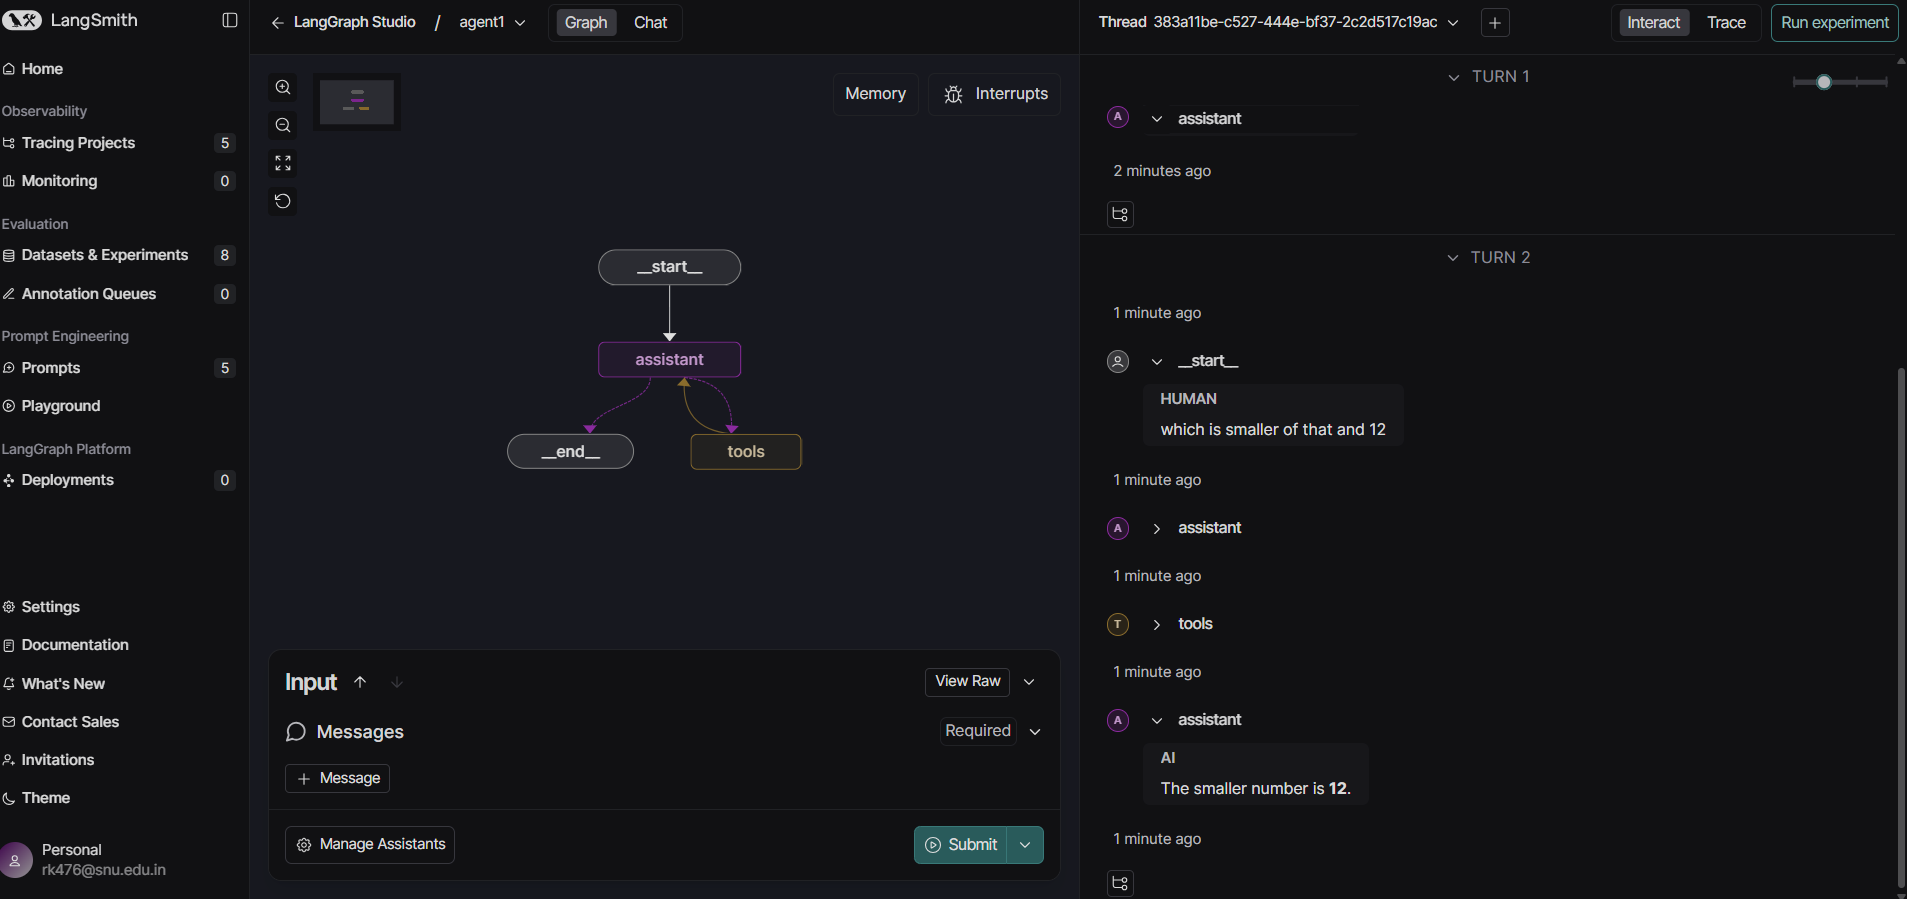